# 策略参数调优

In [1]:
import datetime

import numpy as np

import pandas as pd

import time

from jqdata import *

from pandas import Series, DataFrame

import matplotlib.pyplot as plt

import seaborn as sns

import itertools

import copy

import pickle



# 定义类'参数分析'

class parameter_analysis(object):

    

    # 定义函数中不同的变量

    def __init__(self, algorithm_id=None):

        self.algorithm_id = algorithm_id            # 回测id

        

        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX

        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为

        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe

        self.backtest_ids = {}                      # 回测结果的 id

        

        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准

        self.benchmark_id = '3ebf21f770961143194ebf9491f57196'                      

        

        self.benchmark_returns = []                 # 新加入的基准的回测回报率

        self.returns = {}                           # 记录所有回报率

        self.excess_returns = {}                    # 记录超额收益率

        self.log_returns = {}                       # 记录收益率的 log 值

        self.log_excess_returns = {}                # 记录超额收益的 log 值

        self.dates = []                             # 回测对应的所有日期

        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤

        self.excess_annual_return = {}              # 计算超额收益率的年化指标

        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外

    

    # 定义排队运行多参数回测函数

    def run_backtest(self,                          #

                     algorithm_id=None,             # 回测策略id

                     running_max=10,                # 回测中同时巡行最大回测数量

                     start_date='2006-01-01',       # 回测的起始日期

                     end_date='2016-11-30',         # 回测的结束日期

                     frequency='day',               # 回测的运行频率

                     initial_cash='1000000',        # 回测的初始持仓金额

                     param_names=[],                # 回测中调整参数涉及的变量

                     param_values=[]                # 回测中每个变量的备选参数值

                     ):

        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id

        if algorithm_id == None: algorithm_id=self.algorithm_id

        

        # 生成所有参数组合并加载到 df 中

        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list

        param_combinations = list(itertools.product(*param_values))

        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值

        to_run_df = pd.DataFrame(param_combinations)

        # 修改列名称为调参变量的名字

        to_run_df.columns = param_names

        to_run_df['backtestID']=''

        to_run_df['state']='waiting'

        to_run_df['times']=0

        



        # 设定运行起始时间和保存格式

        start = time.time()

        # 记录结束的运行回测

        finished_backtests = {}

        # 记录运行中的回测

        running_backtests = {}

        failed_backtests={}

        running_count=0



        # 总运行回测数目，等于排列组合中的元素个数

        total_backtest_num = len(param_combinations)

        # 记录回测结果的回报率

        all_results = {}

        # 记录回测结果的各项指标

        all_evaluations = {}

        

        # 在运行开始时显示

        print '【已完成|运行中|待运行||失败】:', 

        # 当运行回测开始后，如果没有全部运行完全的话：

        while len(to_run_df[(to_run_df.state=='waiting') | (to_run_df.state=='running')].index)>0:

            # 显示运行、完成和待运行的回测个数

            print('[%s|%s|%s||%s].' % (len(finished_backtests), 

                                   len(running_backtests), 

                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)- len(failed_backtests)),

                                    len(failed_backtests)  

                                      )),

            # 把可用的空位进行跑回测

            for index in (to_run_df[to_run_df.state=='waiting'].index):

                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值

                if running_count>=running_max:

                    continue

                params = to_run_df.ix[index,param_names].to_dict()

                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容

                backtest = create_backtest(algorithm_id = algorithm_id,

                                           start_date = start_date, 

                                           end_date = end_date, 

                                           frequency = frequency, 

                                           initial_cash = initial_cash, 

                                           extras = params, 

                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值

                                           name =str( params).replace('{','').replace('}','').replace('\'','')

                                           )

                # 记录运行中 i 回测的回测 id

                to_run_df.at[index,'backtestID'] = backtest

                to_run_df.at[index,'state']='running'

                to_run_df.at[index,'times']=to_run_df.at[index,'times']+1

                running_count=running_count+1



            # 获取回测结果

            failed = []

            finished = []

            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数



            for index in to_run_df[to_run_df.state=='running'].index:

                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id

                bt = get_backtest(to_run_df.at[index,'backtestID'])

                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束

                status = bt.get_status()

                # 当运行回测失败

                if status in [ 'failed','canceled','deleted']:

                    # 失败 list 中记录对应的回测结果 id

                    failed.append(index)

                # 当运行回测成功时

                elif status == 'done':

                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的

                    finished.append(index)

                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict

                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict

                    all_results[index] = bt.get_results()

                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe

                    all_evaluations[index] = bt.get_risk()

            # 记录运行中回测结果 id 的 list 中删除失败的运行

            for index in failed:

                if to_run_df.at[index,'times']<3:

                    to_run_df.at[index,'state']='waiting'

                else:

                    to_run_df.at[index,'state']='failed'



            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测

            for index in finished:

                to_run_df.at[index,'state']='done'

            

            running_count=len(to_run_df[to_run_df.state=='running'].index)

            running_backtests=to_run_df[to_run_df.state=='running']['backtestID'].to_dict()

            finished_backtests=to_run_df[to_run_df.state=='done']['backtestID'].to_dict()

            failed_backtests=to_run_df[to_run_df.state=='failed']['backtestID'].to_dict()

            

            # 当一组同时运行的回测结束时报告时间

            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 :

                # 记录当时时间

                middle = time.time()

                # 计算剩余时间，假设没工作量时间相等的话

                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)

                # print 当前运行时间

                print('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 

                                          str(round(remain_time / 60.0 / 60.0,3)))),

            # 5秒钟后再跑一下

            time.sleep(5) 

        # 记录结束时间

        end = time.time() 

        print ''

        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 

                                           str(round((end-start)/60.0/60.0,2)))),

        # 对应修改类内部对应

        self.params_df = to_run_df.ix[:,param_names]

        self.results = all_results

        self.evaluations = all_evaluations

        self.backtest_ids = finished_backtests





    #7 最大回撤计算方法

    def find_max_drawdown(self, returns):

        # 定义最大回撤的变量

        result = 0

        # 记录最高的回报率点

        historical_return = 0

        # 遍历所有日期

        for i in range(len(returns)):

            # 最高回报率记录

            historical_return = max(historical_return, returns[i])

            # 最大回撤记录

            drawdown = 1-(returns[i] + 1) / (historical_return + 1)

            # 记录最大回撤

            result = max(drawdown, result)

        # 返回最大回撤值

        return result



    # log 收益、新基准下超额收益和相对与新基准的最大回撤

    def organize_backtest_results(self, benchmark_id=None):

        # 若新基准的回测结果 id 没给出

        if benchmark_id==None:

            # 使用默认的基准回报率，默认的基准在回测策略中设定

            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]

        # 当新基准指标给出后    

        else:

            # 基准使用新加入的基准回测结果

            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]

        # 回测日期为结果中记录的第一项对应的日期

        self.dates = [x['time'] for x in self.results[0]]

        

        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据

        # 由 {key：{u'benchmark_returns': 0.022480100091729405,

        #           u'returns': 0.03184566700000002,

        #           u'time': u'2006-02-14'}} 格式转化为：

        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list

        for key in self.results.keys():

            self.returns[key] = [x['returns'] for x in self.results[key]]

        # 生成对于基准（或新基准）的超额收益率

        for key in self.results.keys():

            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]

        # 生成 log 形式的收益率

        for key in self.results.keys():

            self.log_returns[key] = [log(x+1) for x in self.returns[key]]

        # 生成超额收益率的 log 形式

        for key in self.results.keys():

            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]

        # 生成超额收益率的最大回撤

        for key in self.results.keys():

            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])

        # 生成年化超额收益率

        for key in self.results.keys():

            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1

        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并

        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)



    # 获取最总分析数据，调用排队回测函数和数据整理的函数    

    def get_backtest_data(self,

                          algorithm_id=None,                         # 回测策略id

                          benchmark_id=None,                         # 新基准回测结果id

                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字

                          running_max=10,                            # 最大同时运行回测数量

                          start_date='2006-01-01',                   # 回测开始时间

                          end_date='2016-11-30',                     # 回测结束日期

                          frequency='day',                           # 回测的运行频率

                          initial_cash='1000000',                    # 回测初始持仓资金

                          param_names=[],                            # 回测需要测试的变量

                          param_values=[]                            # 对应每个变量的备选参数

                          ):

        # 调运排队回测函数，传递对应参数

        self.run_backtest(algorithm_id=algorithm_id,

                          running_max=running_max,

                          start_date=start_date,

                          end_date=end_date,

                          frequency=frequency,

                          initial_cash=initial_cash,

                          param_names=param_names,

                          param_values=param_values

                          )

        # 回测结果指标中加入 log 收益率和超额收益率等指标

        self.organize_backtest_results(benchmark_id)

        # 生成 dict 保存所有结果。

        results = {'returns':self.returns,

                   'excess_returns':self.excess_returns,

                   'log_returns':self.log_returns,

                   'log_excess_returns':self.log_excess_returns,

                   'dates':self.dates,

                   'benchmark_returns':self.benchmark_returns,

                   'evaluations':self.evaluations,

                   'params_df':self.params_df,

                   'backtest_ids':self.backtest_ids,

                   'excess_max_drawdown':self.excess_max_drawdown,

                   'excess_annual_return':self.excess_annual_return,

                   'evaluations_df':self.evaluations_df}

        # 保存 pickle 文件

        pickle_file = open(file_name, 'wb')

        pickle.dump(results, pickle_file)

        pickle_file.close()



    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    

    def read_backtest_data(self, file_name='results.pkl'):

        pickle_file = open(file_name, 'rb')

        results = pickle.load(pickle_file)

        self.returns = results['returns']

        self.excess_returns = results['excess_returns']

        self.log_returns = results['log_returns']

        self.log_excess_returns = results['log_excess_returns']

        self.dates = results['dates']

        self.benchmark_returns = results['benchmark_returns']

        self.evaluations = results['evaluations']

        self.params_df = results['params_df']

        self.backtest_ids = results['backtest_ids']

        self.excess_max_drawdown = results['excess_max_drawdown']

        self.excess_annual_return = results['excess_annual_return']

        self.evaluations_df = results['evaluations_df']



    # 回报率折线图    

    def plot_returns(self):

        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；

        fig = plt.figure(figsize=(20,8))

        ax = fig.add_subplot(1,1,1)

        # 作图

        for key in self.returns.keys():

            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)

        # 设定benchmark曲线并标记

        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 

        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]

        plt.xticks(ticks, [self.dates[i] for i in ticks])

        # 设置图例样式

        ax.legend(loc = 2, fontsize = 10)

        # 设置y标签样式

        ax.set_ylabel('returns',fontsize=20)

        # 设置x标签样式

        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])

        # 设置图片标题样式

        ax.set_title("Strategy's performances with different parameters", fontsize=21)

        plt.xlim(0, len(self.returns[0]))



    # 超额收益率图    

    def plot_excess_returns(self):

        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；

        fig = plt.figure(figsize=(20,8))

        ax = fig.add_subplot(110)

        # 作图

        for key in self.returns.keys():

            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)

        # 设定benchmark曲线并标记

        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')

        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]

        plt.xticks(ticks, [self.dates[i] for i in ticks])

        # 设置图例样式

        ax.legend(loc = 2, fontsize = 10)

        # 设置y标签样式

        ax.set_ylabel('excess returns',fontsize=20)

        # 设置x标签样式

        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])

        # 设置图片标题样式

        ax.set_title("Strategy's performances with different parameters", fontsize=21)

        plt.xlim(0, len(self.excess_returns[0]))



    # log回报率图    

    def plot_log_returns(self):

        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；

        fig = plt.figure(figsize=(20,8))

        ax = fig.add_subplot(110)

        # 作图

        for key in self.returns.keys():

            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)

        # 设定benchmark曲线并标记

        ax.plot(range(len(self.benchmark_returns)), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')

        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]

        plt.xticks(ticks, [self.dates[i] for i in ticks])

        # 设置图例样式

        ax.legend(loc = 2, fontsize = 10)

        # 设置y标签样式

        ax.set_ylabel('log returns',fontsize=20)

        # 设置图片标题样式

        ax.set_title("Strategy's performances with different parameters", fontsize=21)

        plt.xlim(0, len(self.log_returns[0]))



    # 超额收益率的log图

    def plot_log_excess_returns(self):

        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；

        fig = plt.figure(figsize=(20,8))

        ax = fig.add_subplot(110)

        # 作图

        for key in self.returns.keys():

            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key)

        # 设定benchmark曲线并标记

        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')

        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]

        plt.xticks(ticks, [self.dates[i] for i in ticks])

        # 设置图例样式

        ax.legend(loc = 2, fontsize = 10)

        # 设置y标签样式

        ax.set_ylabel('log excess returns',fontsize=20)

        # 设置图片标题样式

        ax.set_title("Strategy's performances with different parameters", fontsize=21)

        plt.xlim(0, len(self.log_excess_returns[0]))





    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动

    def get_eval4_bar(self, sort_by=[]): 

        

        sorted_params = self.params_df

        for by in sort_by:

            sorted_params = sorted_params.sort(by)

        indices = sorted_params.index

        

        fig = plt.figure(figsize=(20,7))



        # 定义位置

        ax1 = fig.add_subplot(221)

        # 设定横轴为对应分位，纵轴为对应指标

        ax1.bar(range(len(indices)), 

                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')

        plt.xticks([x+0.3 for x in range(len(indices))], indices)

        # 设置图例样式

        ax1.legend(loc='best',fontsize=15)

        # 设置y标签样式

        ax1.set_ylabel('Algorithm_return', fontsize=15)

        # 设置y标签样式

        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])

        # 设置图片标题样式

        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)

        # x轴范围

        plt.xlim(0, len(indices))



        # 定义位置

        ax2 = fig.add_subplot(224)

        # 设定横轴为对应分位，纵轴为对应指标

        ax2.bar(range(len(indices)), 

                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')

        plt.xticks([x+0.3 for x in range(len(indices))], indices)

        # 设置图例样式

        ax2.legend(loc='best',fontsize=15)

        # 设置y标签样式

        ax2.set_ylabel('Max_drawdown', fontsize=15)

        # 设置x标签样式

        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])

        # 设置图片标题样式

        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)

        # x轴范围

        plt.xlim(0, len(indices))



        # 定义位置

        ax3 = fig.add_subplot(223)

        # 设定横轴为对应分位，纵轴为对应指标

        ax3.bar(range(len(indices)),

                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')

        plt.xticks([x+0.3 for x in range(len(indices))], indices)

        # 设置图例样式

        ax3.legend(loc='best',fontsize=15)

        # 设置y标签样式

        ax3.set_ylabel('Sharpe', fontsize=15)

        # 设置x标签样式

        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])

        # 设置图片标题样式

        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)

        # x轴范围

        plt.xlim(0, len(indices))



        # 定义位置

        ax4 = fig.add_subplot(222)

        # 设定横轴为对应分位，纵轴为对应指标

        ax4.bar(range(len(indices)), 

                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')

        plt.xticks([x+0.3 for x in range(len(indices))], indices)

        # 设置图例样式

        ax4.legend(loc='best',fontsize=15)

        # 设置y标签样式

        ax4.set_ylabel('Algorithm_volatility', fontsize=15)

        # 设置x标签样式

        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])

        # 设置图片标题样式

        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)

        # x轴范围

        plt.xlim(0, len(indices))

        

    #14 年化回报和最大回撤，正负双色表示

    def get_eval(self, sort_by=[]):



        sorted_params = self.params_df

        for by in sort_by:

            sorted_params = sorted_params.sort(by)

        indices = sorted_params.index

        

        # 大小

        fig = plt.figure(figsize = (20, 8))

        # 图1位置

        ax = fig.add_subplot(110)

        # 生成图超额收益率的最大回撤

        ax.bar([x+0.3 for x in range(len(indices))],

               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  

                     width = 0.6, label = 'Max_drawdown', zorder=10)

        # 图年化超额收益

        ax.bar([x for x in range(len(indices))],

               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 

                     width = 0.6, label = 'Annual_return')

        plt.xticks([x+0.3 for x in range(len(indices))], indices)

        # 设置图例样式

        ax.legend(loc='best',fontsize=15)

        # 基准线

        plt.plot([0, len(indices)], [0, 0], c='k', 

                 linestyle='--', label='zero')

        # 设置图例样式

        ax.legend(loc='best',fontsize=15)

        # 设置y标签样式

        ax.set_ylabel('Max_drawdown', fontsize=15)

        # 设置x标签样式

        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])

        # 设置图片标题样式

        ax.set_title("Strategy's performances of different quantile", fontsize=15)

        #   设定x轴长度

        plt.xlim(0, len(indices))





    #14 超额收益的年化回报和最大回撤

    # 加入新的benchmark后超额收益和

    def get_excess_eval(self, sort_by=[]):



        sorted_params = self.params_df

        for by in sort_by:

            sorted_params = sorted_params.sort(by)

        indices = sorted_params.index

        

        # 大小

        fig = plt.figure(figsize = (20, 8))

        # 图1位置

        ax = fig.add_subplot(110)

        # 生成图超额收益率的最大回撤

        ax.bar([x+0.3 for x in range(len(indices))],

               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  

                     width = 0.6, label = 'Excess_max_drawdown')

        # 图年化超额收益

        ax.bar([x for x in range(len(indices))],

               [self.excess_annual_return[x] for x in indices], color = 'r', 

                     width = 0.6, label = 'Excess_annual_return')

        plt.xticks([x+0.3 for x in range(len(indices))], indices)

        # 设置图例样式

        ax.legend(loc='best',fontsize=15)

        # 基准线

        plt.plot([0, len(indices)], [0, 0], c='k', 

                 linestyle='--', label='zero')

        # 设置图例样式

        ax.legend(loc='best',fontsize=15)

        # 设置y标签样式

        ax.set_ylabel('Max_drawdown', fontsize=15)

        # 设置x标签样式

        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])

        # 设置图片标题样式

        ax.set_title("Strategy's performances of different quantile", fontsize=15)

        #   设定x轴长度

        plt.xlim(0, len(indices))

In [3]:
pa =parameter_analysis('59539380556dd2b66b9be5b2d8c481d3') #在聚宽中调用策略ID回测

In [4]:
pa.get_backtest_data(file_name= 'results_days.pkl',

                          running_max = 10,

                          start_date ='2012-01-01',

                          end_date = '2018-04-18',

                          frequency = 'day',

                          initial_cash ='1000000',

                          param_names =['tralling_stop_X_ATR','div'],

                          param_values =[[1,1.5,2,2.5,3,3.5,4,4.5],[0.2]]

                          )

【已完成|运行中|待运行||失败】: [0|0|8||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0]. [0|8|0||0

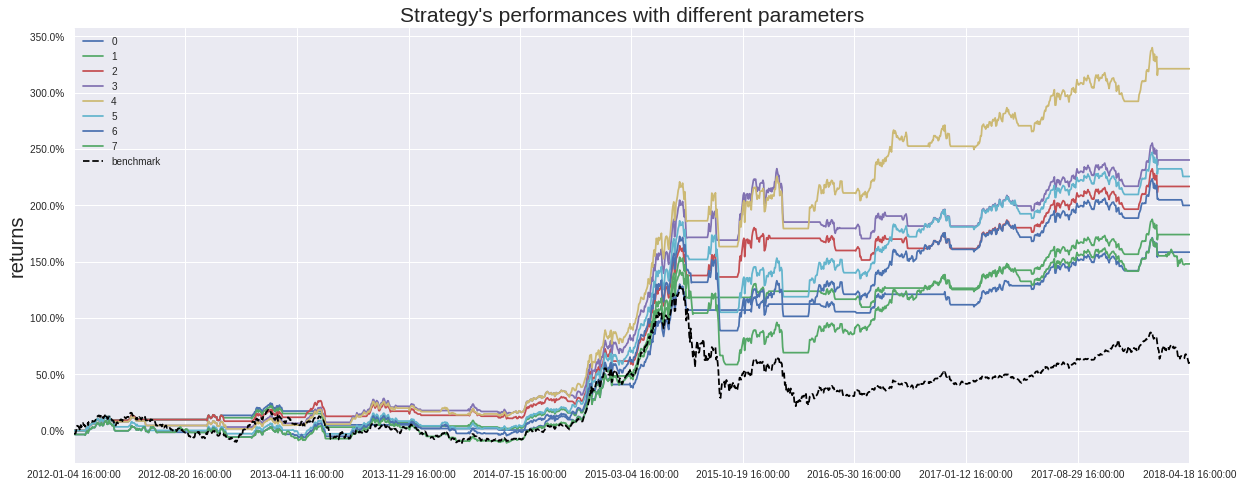

In [5]:
pa.plot_returns()

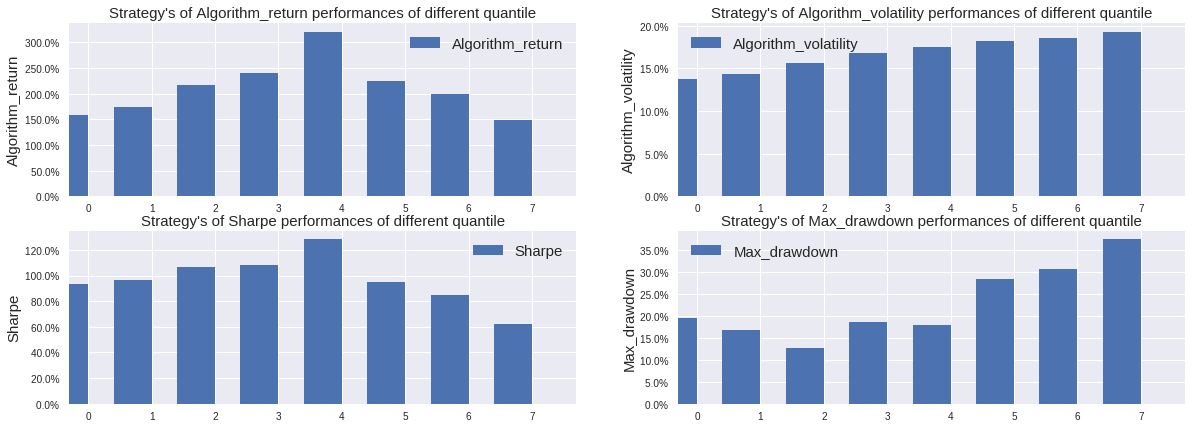

In [6]:
pa.get_eval4_bar()

第4组参数性能最好，即3个日线ATR